In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_h(x, y, t):
    return -torch.sin(x)*torch.sin(y)*torch.cos(t)

def initial_condition_h(x, y):
    return -torch.sin(x)*torch.sin(y) 

In [3]:
# Define the exact solution p = E
def exact_solution_e1(x, y, t):
    return -torch.sin(x)*torch.sin(t)*torch.cos(y)

def initial_condition_e1(x, y):
    return 0.0*torch.sin(x) 

In [4]:
# Define the exact solution p = E
def exact_solution_e2(x, y, t):
    return torch.sin(y)*torch.sin(t)*torch.cos(x)

def initial_condition_e2(x, y):
    return 0.0*torch.sin(x) 

In [5]:
# assigning number of points
initial_pts = 200 
left_boundary_pts = 200 
right_boundary_pts = 200
back_boundary_pts = 200
front_boundary_pts = 200
residual_pts = 1000

In [6]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = torch.rand((initial_pts,1)) # initial pts
y_init = torch.rand((initial_pts,1))
t_init =  0*x_init
init =  torch.cat([x_init, y_init, t_init],1)
h_init = initial_condition_h(init[:,0], init[:, 1]).reshape(-1, 1)
e1_init = initial_condition_e1(init[:,0], init[:, 1]).reshape(-1, 1)
e2_init = initial_condition_e2(init[:,0], init[:, 1]).reshape(-1, 1)
w_init = torch.cat([h_init, e1_init, e2_init],1)


xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
yb_left = torch.rand((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, yb_left, tb_left ],1)
h_b_l = exact_solution_h(xb_left, yb_left, tb_left).reshape(-1, 1)
e1_b_l = exact_solution_e1(xb_left, yb_left, tb_left).reshape(-1, 1)
e2_b_l = exact_solution_e2(xb_left, yb_left, tb_left).reshape(-1, 1)



xb_right = torch.ones((right_boundary_pts, 1)) # right spatial boundary
yb_right = torch.rand((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, yb_right, tb_right ],1)
h_b_r = exact_solution_h(xb_right, yb_right, tb_right).reshape(-1, 1)
e1_b_r = exact_solution_e1(xb_right, yb_right, tb_right).reshape(-1, 1)
e2_b_r = exact_solution_e2(xb_right, yb_right, tb_right).reshape(-1, 1)



xb_front = torch.rand((front_boundary_pts, 1)) # front spatial boundary
yb_front = torch.zeros((front_boundary_pts, 1)) # front spatial boundary
tb_front = torch.rand((front_boundary_pts, 1)) # 
b_front = torch.cat([xb_front, yb_front, tb_front ],1)
h_b_f = exact_solution_h(xb_front, yb_front, tb_front).reshape(-1, 1)
e1_b_f = exact_solution_e1(xb_front, yb_front, tb_front).reshape(-1, 1)
e2_b_f = exact_solution_e2(xb_front, yb_front, tb_front).reshape(-1, 1)



xb_back = torch.rand((back_boundary_pts, 1)) # back spatial boundary
yb_back = torch.ones((back_boundary_pts, 1)) # back spatial boundary
tb_back = torch.rand((back_boundary_pts, 1)) # back boundary pts
b_back = torch.cat([xb_back, yb_back, tb_back ],1)
h_b_b = exact_solution_h(xb_back, yb_back, tb_back).reshape(-1, 1)
e1_b_b = exact_solution_e1(xb_back, yb_back, tb_back).reshape(-1, 1)
e2_b_b = exact_solution_e2(xb_back, yb_back, tb_back).reshape(-1, 1)



x_interior = torch.rand((residual_pts, 1))
y_interior = torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, y_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right, b_front, b_back), batch_size=200, shuffle=False)

In [7]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [8]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [9]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [10]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [11]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right, bd_front, bd_back) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                h_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                e1_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                e2_initial_pred_ = w_initial_pred_[:,2].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_h_ini = torch.autograd.grad(h_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                h_initial_t = grad_h_ini[:, 2]
                
                grad_e1_ini = torch.autograd.grad(e1_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e1_initial_t = grad_e1_ini[:, 2]
                
                grad_e2_ini = torch.autograd.grad(e2_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e2_initial_t = grad_e2_ini[:, 2]
                
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                h_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                e1_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                e2_bd_left_pred_ = w_bd_left_pred_[:,2].reshape(-1,1)
                
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                h_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                e1_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                e2_bd_right_pred_ = w_bd_right_pred_[:,2].reshape(-1,1)
                
                # for front boundary
                w_bd_front_pred_ = model(bd_front)
                h_bd_front_pred_ = w_bd_front_pred_[:,0].reshape(-1,1)
                e1_bd_front_pred_ = w_bd_front_pred_[:,1].reshape(-1,1)
                e2_bd_front_pred_ = w_bd_front_pred_[:,2].reshape(-1,1)
                
                # for back boundary
                w_bd_back_pred_ = model(bd_back)
                h_bd_back_pred_ = w_bd_back_pred_[:,0].reshape(-1,1)
                e1_bd_back_pred_ = w_bd_back_pred_[:,1].reshape(-1,1)
                e2_bd_back_pred_ = w_bd_back_pred_[:,2].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                h_hat = w_hat[:,0].reshape(-1,1)
                e1_hat = w_hat[:,1].reshape(-1,1)
                e2_hat = w_hat[:,2].reshape(-1,1)
                
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                
                grad_h_hat = torch.autograd.grad(h_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                h_x = grad_h_hat[:, 0].reshape(-1,1)
                h_y = grad_h_hat[:, 1].reshape(-1,1)
                
                grad_e1_hat = torch.autograd.grad(e1_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e1_x = grad_e1_hat[:, 0].reshape(-1,1)
                e1_y = grad_e1_hat[:, 1].reshape(-1,1)
                
                grad_e2_hat = torch.autograd.grad(e2_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e2_x = grad_e2_hat[:, 0].reshape(-1,1)
                e2_y = grad_e2_hat[:, 1].reshape(-1,1)
                
                h_t = grad_h_hat[:, 2].reshape(-1,1)
                e1_t = grad_e1_hat[:, 2].reshape(-1,1)
                e2_t = grad_e2_hat[:, 2].reshape(-1,1)
                
                
                # Item 1. below
                loss1 = torch.mean((h_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + torch.mean((2*h_t.reshape(-1, ) + e2_x.reshape(-1, ) - e1_y.reshape(-1, ))**p)+torch.mean((h_bd_left_pred_.reshape(-1,)- h_b_l.reshape(-1,))**p) + torch.mean((h_bd_right_pred_.reshape(-1,)- h_b_r.reshape(-1,))**p) +torch.mean((h_bd_front_pred_.reshape(-1,)- h_b_f.reshape(-1,))**p) + torch.mean((h_bd_back_pred_.reshape(-1,)- h_b_b.reshape(-1,))**p)
                loss2 = torch.mean((e1_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((3*e1_t.reshape(-1, )  - h_y.reshape(-1, ) + 2*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]))**p) +torch.mean((e1_bd_left_pred_.reshape(-1,)- e1_b_l.reshape(-1,))**p) + torch.mean((e1_bd_right_pred_.reshape(-1,)- e1_b_r.reshape(-1,))**p) +torch.mean((e1_bd_front_pred_.reshape(-1,)- e1_b_f.reshape(-1,))**p) + torch.mean((e1_bd_back_pred_.reshape(-1,)- e1_b_b.reshape(-1,))**p)
                loss3 = torch.mean((e2_initial_pred_.reshape(-1, ) - w_initial[:,2].reshape(-1, ))**p)+ torch.mean((2*e2_t.reshape(-1, )  + h_x.reshape(-1, ) - torch.cos(interior[:, 0])*torch.cos(interior[:, 2])*torch.sin(interior[:, 1]))**p) +torch.mean((e2_bd_left_pred_.reshape(-1,)- e2_b_l.reshape(-1,))**p) + torch.mean((e2_bd_right_pred_.reshape(-1,)- e2_b_r.reshape(-1,))**p) +torch.mean((e2_bd_front_pred_.reshape(-1,)- e2_b_f.reshape(-1,))**p) + torch.mean((e2_bd_back_pred_.reshape(-1,)- e2_b_b.reshape(-1,))**p)
                loss = loss1 + loss2 + loss3
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [12]:
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  94.36968994140625
################################  1  ################################
Loss:  92.66423797607422
################################  2  ################################
Loss:  77.3872299194336
################################  3  ################################
Loss:  57.76629638671875
################################  4  ################################
Loss:  41.545021057128906
################################  5  ################################
Loss:  34.75366973876953
################################  6  ################################
Loss:  30.717031478881836
################################  7  ################################
Loss:  27.3055419921875
################################  8  ################################
Loss:  24.13738250732422
################################  9  ################################
Loss:  21.117130279541016
################################  10  ###########

Loss:  0.012526980601251125
################################  87  ################################
Loss:  0.012023823335766792
################################  88  ################################
Loss:  0.01155991479754448
################################  89  ################################
Loss:  0.011148020625114441
################################  90  ################################
Loss:  0.010778160765767097
################################  91  ################################
Loss:  0.010422075167298317
################################  92  ################################
Loss:  0.010097319260239601
################################  93  ################################
Loss:  0.009779797866940498
################################  94  ################################
Loss:  0.009492699056863785
################################  95  ################################
Loss:  0.009199265390634537
################################  96  ################################
Loss:  0.00

Loss:  0.0015210913261398673
################################  186  ################################
Loss:  0.0014991187490522861
################################  187  ################################
Loss:  0.001478042220696807
################################  188  ################################
Loss:  0.001457087229937315
################################  189  ################################
Loss:  0.0014366069808602333
################################  190  ################################
Loss:  0.001416540239006281
################################  191  ################################
Loss:  0.001396950799971819
################################  192  ################################
Loss:  0.0013778661377727985
################################  193  ################################
Loss:  0.0013598467921838164
################################  194  ################################
Loss:  0.001342832576483488
################################  195  ############################

Loss:  0.0007482603541575372
################################  282  ################################
Loss:  0.0007438117172569036
################################  283  ################################
Loss:  0.0007381921750493348
################################  284  ################################
Loss:  0.0007339970325119793
################################  285  ################################
Loss:  0.0007293048547580838
################################  286  ################################
Loss:  0.0007240347331389785
################################  287  ################################
Loss:  0.0007188530289568007
################################  288  ################################
Loss:  0.0007133287144824862
################################  289  ################################
Loss:  0.000708159408532083
################################  290  ################################
Loss:  0.000701945333275944
################################  291  #########################

Loss:  0.0004989744629710913
################################  370  ################################
Loss:  0.0004973760806024075
################################  371  ################################
Loss:  0.0004957836936227977
################################  372  ################################
Loss:  0.0004941857187077403
################################  373  ################################
Loss:  0.0004925838438794017
################################  374  ################################
Loss:  0.0004909379640594125
################################  375  ################################
Loss:  0.0004892498254776001
################################  376  ################################
Loss:  0.0004875858430750668
################################  377  ################################
Loss:  0.00048595425323583186
################################  378  ################################
Loss:  0.00048430723836645484
################################  379  #####################

Loss:  0.00037076009903103113
################################  464  ################################
Loss:  0.0003690790617838502
################################  465  ################################
Loss:  0.00036788033321499825
################################  466  ################################
Loss:  0.00036609056405723095
################################  467  ################################
Loss:  0.00036440411349758506
################################  468  ################################
Loss:  0.00036254897713661194
################################  469  ################################
Loss:  0.00036053964868187904
################################  470  ################################
Loss:  0.000358371326001361
################################  471  ################################
Loss:  0.00035627506440505385
################################  472  ################################
Loss:  0.0003541775222402066
################################  473  #################

Loss:  0.00025899027241393924
################################  565  ################################
Loss:  0.0002581869484856725
################################  566  ################################
Loss:  0.0002573218080215156
################################  567  ################################
Loss:  0.0002563440939411521
################################  568  ################################
Loss:  0.000255468359682709
################################  569  ################################
Loss:  0.00025461704353801906
################################  570  ################################
Loss:  0.0002537851978559047
################################  571  ################################
Loss:  0.000252970727160573
################################  572  ################################
Loss:  0.00025217427173629403
################################  573  ################################
Loss:  0.00025138951605185866
################################  574  #####################

Loss:  0.00020269509695935994
################################  652  ################################
Loss:  0.0002017646620515734
################################  653  ################################
Loss:  0.0002008424635278061
################################  654  ################################
Loss:  0.0001999256492126733
################################  655  ################################
Loss:  0.00019895816512871534
################################  656  ################################
Loss:  0.0001980193774215877
################################  657  ################################
Loss:  0.00019705924205482006
################################  658  ################################
Loss:  0.00019619686645455658
################################  659  ################################
Loss:  0.0001953563914867118
################################  660  ################################
Loss:  0.00019446064834482968
################################  661  ##################

Loss:  0.00015152007108554244
################################  747  ################################
Loss:  0.00015111902030184865
################################  748  ################################
Loss:  0.00015070792869664729
################################  749  ################################
Loss:  0.00015031121438369155
################################  750  ################################
Loss:  0.00014991519856266677
################################  751  ################################
Loss:  0.00014950775948818773
################################  752  ################################
Loss:  0.00014910433674231172
################################  753  ################################
Loss:  0.00014870084123685956
################################  754  ################################
Loss:  0.00014830895815975964
################################  755  ################################
Loss:  0.00014792774163652211
################################  756  #############

Loss:  0.0001296379487030208
################################  833  ################################
Loss:  0.000129402382299304
################################  834  ################################
Loss:  0.00012915898696519434
################################  835  ################################
Loss:  0.00012889920617453754
################################  836  ################################
Loss:  0.00012862816220149398
################################  837  ################################
Loss:  0.0001283259771298617
################################  838  ################################
Loss:  0.0001280162250623107
################################  839  ################################
Loss:  0.00012769372551701963
################################  840  ################################
Loss:  0.00012737588258460164
################################  841  ################################
Loss:  0.0001270513457711786
################################  842  ###################

Loss:  9.991900878958404e-05
################################  923  ################################
Loss:  9.973865962820128e-05
################################  924  ################################
Loss:  9.957971633411944e-05
################################  925  ################################
Loss:  9.94268775684759e-05
################################  926  ################################
Loss:  9.927316568791866e-05
################################  927  ################################
Loss:  9.909929940477014e-05
################################  928  ################################
Loss:  9.893960668705404e-05
################################  929  ################################
Loss:  9.877213597064838e-05
################################  930  ################################
Loss:  9.858814155450091e-05
################################  931  ################################
Loss:  9.840268467087299e-05
################################  932  ########################

Loss:  7.925455429358408e-05
################################  1008  ################################
Loss:  7.90166377555579e-05
################################  1009  ################################
Loss:  7.879448094172403e-05
################################  1010  ################################
Loss:  7.857446325942874e-05
################################  1011  ################################
Loss:  7.835992437321693e-05
################################  1012  ################################
Loss:  7.814827404217795e-05
################################  1013  ################################
Loss:  7.793303666403517e-05
################################  1014  ################################
Loss:  7.771377568133175e-05
################################  1015  ################################
Loss:  7.751243538223207e-05
################################  1016  ################################
Loss:  7.732296944595873e-05
################################  1017  ##############

Loss:  6.447279884014279e-05
################################  1098  ################################
Loss:  6.437717820517719e-05
################################  1099  ################################
Loss:  6.427619518944994e-05
################################  1100  ################################
Loss:  6.417389522539452e-05
################################  1101  ################################
Loss:  6.407337059499696e-05
################################  1102  ################################
Loss:  6.396595563273877e-05
################################  1103  ################################
Loss:  6.386481982190162e-05
################################  1104  ################################
Loss:  6.374669465003535e-05
################################  1105  ################################
Loss:  6.359864346450195e-05
################################  1106  ################################
Loss:  6.342408596538007e-05
################################  1107  #############

Loss:  5.369157588575035e-05
################################  1191  ################################
Loss:  5.35730468982365e-05
################################  1192  ################################
Loss:  5.346965554053895e-05
################################  1193  ################################
Loss:  5.3345487685874104e-05
################################  1194  ################################
Loss:  5.323793084244244e-05
################################  1195  ################################
Loss:  5.310142660164274e-05
################################  1196  ################################
Loss:  5.296649760566652e-05
################################  1197  ################################
Loss:  5.280019831843674e-05
################################  1198  ################################
Loss:  5.26652074768208e-05
################################  1199  ################################
Loss:  5.2506144129438326e-05
################################  1200  #############

Loss:  4.256076135789044e-05
################################  1279  ################################
Loss:  4.2514409869909286e-05
################################  1280  ################################
Loss:  4.247164906701073e-05
################################  1281  ################################
Loss:  4.24247446062509e-05
################################  1282  ################################
Loss:  4.23685232817661e-05
################################  1283  ################################
Loss:  4.231233469909057e-05
################################  1284  ################################
Loss:  4.225364682497457e-05
################################  1285  ################################
Loss:  4.21984150307253e-05
################################  1286  ################################
Loss:  4.2145133193116635e-05
################################  1287  ################################
Loss:  4.2090658098459244e-05
################################  1288  #############

################################  1364  ################################
Loss:  3.899752118741162e-05
################################  1365  ################################
Loss:  3.8965717976680025e-05
################################  1366  ################################
Loss:  3.8932845200179145e-05
################################  1367  ################################
Loss:  3.89001434086822e-05
################################  1368  ################################
Loss:  3.8865458918735385e-05
################################  1369  ################################
Loss:  3.8830457924632356e-05
################################  1370  ################################
Loss:  3.87936488550622e-05
################################  1371  ################################
Loss:  3.8756494177505374e-05
################################  1372  ################################
Loss:  3.8717666029697284e-05
################################  1373  ################################
Loss:

Loss:  3.520537939039059e-05
################################  1454  ################################
Loss:  3.515887146932073e-05
################################  1455  ################################
Loss:  3.511147224344313e-05
################################  1456  ################################
Loss:  3.5063920222455636e-05
################################  1457  ################################
Loss:  3.50198351952713e-05
################################  1458  ################################
Loss:  3.497519719530828e-05
################################  1459  ################################
Loss:  3.493182884994894e-05
################################  1460  ################################
Loss:  3.488742368062958e-05
################################  1461  ################################
Loss:  3.483679029159248e-05
################################  1462  ################################
Loss:  3.478355938568711e-05
################################  1463  #############

In [13]:
# saving and loading Model
FILE = "maxwell2D_1.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [14]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [15]:
x_test = torch.linspace(0, 1, 10000).reshape(-1,1)
y_test = torch.linspace(0, 1, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, y_test, t_test],1)
h_test = exact_solution_h(x_test, y_test, t_test).reshape(-1,1)
e1_test = exact_solution_e1(x_test, y_test, t_test).reshape(-1,1)
e2_test = exact_solution_e2(x_test, y_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
h_test_pred = w_test_pred[:,0].reshape(-1,1)
e1_test_pred = w_test_pred[:,1].reshape(-1,1)
e2_test_pred = w_test_pred[:,2].reshape(-1,1)

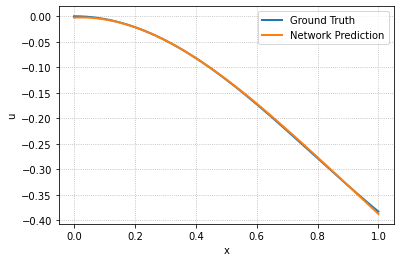

In [16]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, h_test, label="Ground Truth",lw=2)
plt.plot(x_test, h_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((h_test_pred - h_test)**2)/torch.mean(h_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.004954184259986505 %


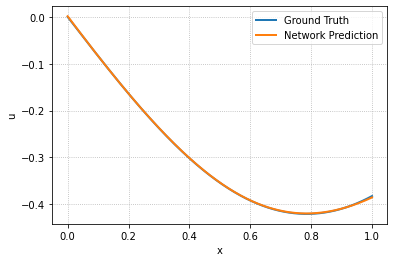

In [18]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, e1_test, label="Ground Truth",lw=2)
plt.plot(x_test, e1_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e1_test_pred - e1_test)**2)/torch.mean(e1_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0004488900231081061 %


In [20]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e2_test_pred - e2_test)**2)/torch.mean(e2_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0015908222849247977 %


In [21]:
# for ploting

In [22]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

NameError: name 'exact_solution_u' is not defined

In [ ]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

In [ ]:

plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

In [ ]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")